In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
fig_width_pt = 247.  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

In [2]:
from EdgeFactory import EdgeFactory
ef = EdgeFactory('default_param.py')
ef.pe.N_X = 244
ef.init_edges()
print(ef.pe.N_X)

244


# manipulating values

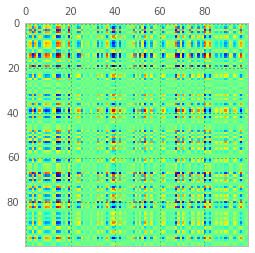

In [3]:
N = 100
a = np.random.randn(N)**2
#w = np.random.randn(N,N)**2
#w += w.T
b = np.random.randn(N)
f = b[:, np.newaxis] * b[np.newaxis, :]
b = np.random.randn(N)
g = b[:, np.newaxis] * b[np.newaxis, :]
plt.matshow(g)

The goal is to solve for the equation

$$
b_i \cdot b_j = w_{ij} \cdot a_i \cdot a_j 
$$

A solution is to use the recursion

$$ 
b_i^{n+1} = 
\frac{\sum_j g_{ij} \cdot a_i \cdot a_j \cdot f_{ij} \cdot b_j^n}{\sum_j (f_{ij} \cdot b_j^n)^ 2 }
$$

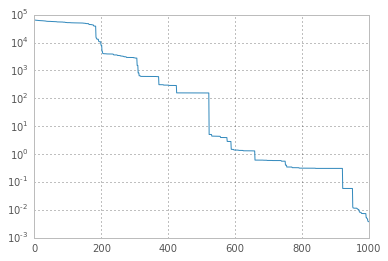

In [4]:
def update(a, b, f, g, i):
    b[i] = np.sum(g[i, :] * a[i] * a * f[i, :] * b)/np.sum((f[i, :] * b)**2)
    return b
def solve(a, f=None, g=None, N_iter=1000):
    b = np.ones(a.shape)
    C = np.zeros((N_iter,))
    if f==None: f = np.ones(g.shape)
    if g==None: g = np.ones(f.shape)
    for i_iter in range(N_iter):
        C[i_iter] = np.sum( (g * a[:, np.newaxis] * a[np.newaxis, :] - f*b[:, np.newaxis] * b[np.newaxis, :])**2 )
        b = update(a, b, f, g, np.random.randint(N))
    return b, C

b, C = solve(a, f, g)
plt.semilogy(C)

In [5]:
ef.patch?

In [6]:
print(a[:, np.newaxis]*a[np.newaxis, :] * a)

[[ 0.     0.141  0.208 ...,  0.003  0.004  0.   ]
 [ 0.004  5.551  8.198 ...,  0.103  0.169  0.   ]
 [ 0.004  6.745  9.962 ...,  0.126  0.205  0.   ]
 ..., 
 [ 0.     0.757  1.119 ...,  0.014  0.023  0.   ]
 [ 0.001  0.968  1.429 ...,  0.018  0.029  0.   ]
 [ 0.     0.025  0.037 ...,  0.     0.001  0.   ]]


> figure 1 : one example image 


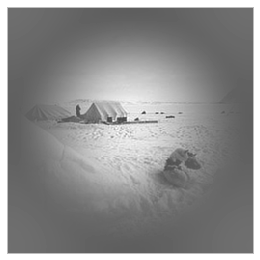

In [7]:
import os, pickle
exp, name_database, i_image = 'srep', 'serre07_targets', 310
matname = exp + '_' + name_database
imagelist = pickle.load( open(os.path.join(ef.pe.matpath, matname + '_images.pickle') ))
edgeslist_targets = np.load(os.path.join(ef.pe.edgematpath, matname + '_edges.npy'))

filename, croparea = imagelist[i_image]
image, filename_, croparea_  = ef.patch(name_database=name_database, filename=filename, croparea=croparea)
print('> figure 1 : one example image ')
# (A) model
fig = pylab.figure(figsize=(fig_width, fig_width))
border = 0.
ax = fig.add_axes((border, border, 1.-2*border, 1.-2*border), axisbg='w')
ax.axis(c='b', lw=0)
#print N_X, image.shape, croparea_
pylab.setp(ax, xticks=[])
pylab.setp(ax, yticks=[])
fig, ax = ef.show_edges(np.empty((5, 0)), fig=fig, a=ax, image=image*1.)
#for format_ in formats: fig.savefig('ms/figure1A.' + format_, dpi=450)
#pylab.close('all')
v_hist_targets = ef.cohistedges(edgeslist_targets[:, :, i_image][..., np.newaxis], display=None)

In [8]:
#edgeslist_targets[0, :, :] = N_X - edgeslist_targets[0, :, :]
#edgeslist_targets[2, :, :] = - edgeslist_targets[2, :, :]

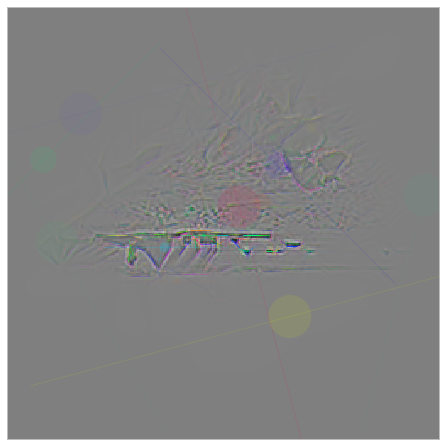

In [9]:
image_ = ef.reconstruct(edgeslist_targets[:, :, i_image])
fig, ax = ef.show_edges(edgeslist_targets[:, :, i_image], image=image_)

In [10]:
exp, name_database, i_image = 'classifier', 'serre07_distractors', 310
edgeslist_distractors = np.load(os.path.join(ef.pe.edgematpath, matname + '_edges.npy'))
print(edgeslist_distractors.shape)
v_hist_distractors = ef.cohistedges(edgeslist_distractors[:, :, i_image][..., np.newaxis], display=None)
print(v_hist_distractors.shape)

(6, 2048, 600)
(6, 12, 24, 5)


In [11]:
print (ef.edges_d.shape)

(7,)


In [12]:
def w_ij(edgeslist, v_hist):
    X, Y = edgeslist[0, :].real, edgeslist[1, :].real
    Theta = edgeslist[2, :].real
    Sf_0 = edgeslist[3, :].real
    value = edgeslist[4, :]
    Weights = np.absolute(value)#/(np.absolute(value)).sum()
    dx = X[:, np.newaxis] - X[np.newaxis, :]
    dy = Y[:, np.newaxis] - Y[np.newaxis, :]
    d = np.sqrt(dx**2 + dy**2) / ef.N_X  # distance
    if ef.pe.scale_invariant: d *= np.sqrt(Sf_0[:, np.newaxis]*Sf_0[np.newaxis, :])/np.sqrt(ef.N_X)
    d *= ef.pe.d_width # distance in visual angle
    theta = Theta[:, np.newaxis] - Theta[np.newaxis, :]
    phi = np.arctan2(dy, dx) - np.pi/2 - Theta[np.newaxis, :]
    phi -= theta/2
    loglevel = np.log2(Sf_0[:, np.newaxis]) - np.log2(Sf_0[np.newaxis, :])
    weights = Weights[:, np.newaxis] * Weights[np.newaxis, :]
    if ef.pe.weight_by_distance:
        weights /= (d + 1.e-6) # warning, some are still at the same position d=0...
    phi = ((phi + np.pi/2  - np.pi/ef.pe.N_phi/2 ) % (np.pi)) - np.pi/2  + np.pi/ef.pe.N_phi/2
    theta = ((theta + np.pi/2 - np.pi/ef.pe.n_theta/2)  % (np.pi) ) - np.pi/2  + np.pi/ef.pe.n_theta/2

    i_d = np.argmin((ef.edges_d[np.newaxis, np.newaxis, :-1] - d[:, :, np.newaxis])**2, axis=-1)
    i_theta = np.argmin((ef.edges_theta[np.newaxis, np.newaxis, :-1] - theta[:, :, np.newaxis])**2, axis=-1)
    i_psi = np.argmin((ef.edges_phi[np.newaxis, np.newaxis, :-1] - phi[:, :, np.newaxis])**2, axis=-1)
    i_loglevel = np.argmin((ef.edges_loglevel[np.newaxis, np.newaxis, :-1] - loglevel[:, :, np.newaxis])**2, axis=-1)
#    print i_d.ravel(), i_d.shape, i_d.max()
#    return v_hist[i_d.ravel(), i_psi.ravel(), i_theta.ravel(), i_loglevel.ravel()]
    return v_hist[i_d, i_psi, i_theta, i_loglevel]

f_ij = w_ij(edgeslist_targets[:, :, i_image], v_hist_targets)
g_ij = w_ij(edgeslist_distractors[:, :, i_image], v_hist_distractors)

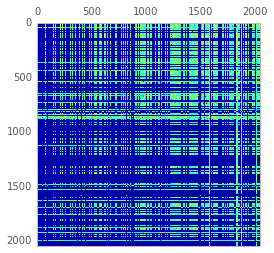

In [13]:
plt.matshow(f_ij)

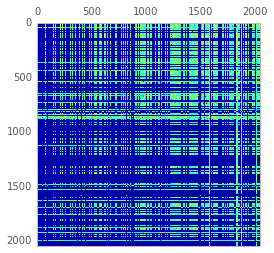

In [14]:
plt.matshow(g_ij)

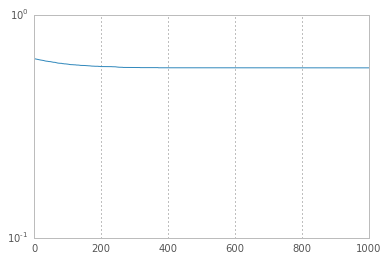

In [15]:
a = np.absolute(edgeslist_targets[4, :, i_image])
a_sign = edgeslist_targets[4, :, i_image] / a
b, C = solve(a, f_ij, g_ij)
plt.semilogy(C)

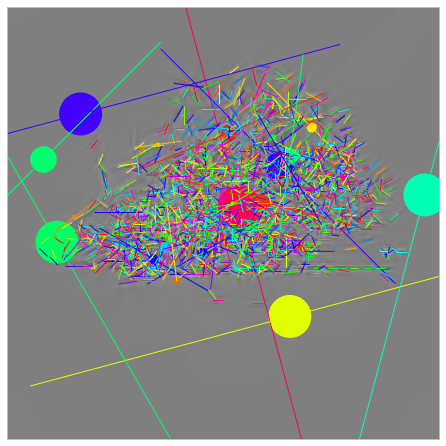

In [16]:
edgeslist_targets[4, :, i_image] = b * a_sign
image_ = ef.reconstruct(edgeslist_targets[:, :, i_image])
#if self.edge.do_whitening: image_ = self.edge.im.dewhitening(image_)
fig, ax = ef.show_edges(edgeslist_targets[:, :, i_image], image=image_*1.)

# generating textures: heuristics on values

In [17]:
def shuffle(edgeslist, N=None):
    if N==None: N = edgeslist_targets.shape[1]
    index_to_shuffle = np.random.permutation(edgeslist_targets.shape[1])[:N]
    for index in range(5):
        edgeslist[index, index_to_shuffle, ...] = np.random.permutation(edgeslist[index, index_to_shuffle, ...].ravel()).reshape(edgeslist[index, index_to_shuffle, ...].shape)
    return edgeslist
edgeslist_shuffled = shuffle(edgeslist_targets, N=128)

In [18]:
Weights = np.absolute(edgeslist_shuffled[4, :, i_image])
value_sign = edgeslist_shuffled[4, :, i_image]/ Weights
Weights[Weights.argsort()] = np.linspace(1./Weights.size, 1., Weights.size)
edgeslist_shuffled[4, :, i_image] = value_sign * Weights

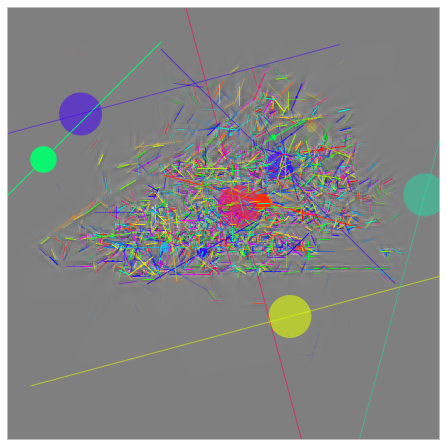

In [19]:
image_ = ef.reconstruct(edgeslist_shuffled[:, :, i_image])
fig, ax = ef.show_edges(edgeslist_shuffled[:, :, i_image], image=image_)

In [20]:
from itertools import izip
def relative_entropy(freq, background):
    KL = 0.
    positives = (freq.ravel() != 0.) & (background.ravel() != 0.)
    for i, (freq, idx) in enumerate(izip(freq, positives)):
        KL += np.sum(freq[idx] * np.log2(freq[idx] / background[idx]))
    return Dkls

def KL(v_hist, v_hist_obs, eps=1e-12):
    if v_hist.sum()==0 or v_hist_obs.sum()==0: print('>X>X>X KL function:  problem with null histograms! <X<X<X<')
    # taking advantage of log(True) = 0 and canceling out null bins in v_hist_obs
    return np.sum(v_hist_obs.ravel()*(np.log(v_hist_obs.ravel()+(v_hist_obs == 0).ravel()) - np.log(v_hist.ravel()+eps)))


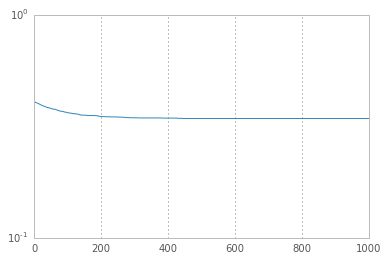

In [21]:
a = np.absolute(edgeslist_targets[4, :, i_image])
a_sign = edgeslist_targets[4, :, i_image] / a

f_ij = w_ij(edgeslist_targets[:, :, i_image], v_hist_targets)
g_ij = w_ij(edgeslist_distractors[:, :, i_image], v_hist_distractors)
b, C = solve(a, f_ij, g_ij)
plt.semilogy(C)

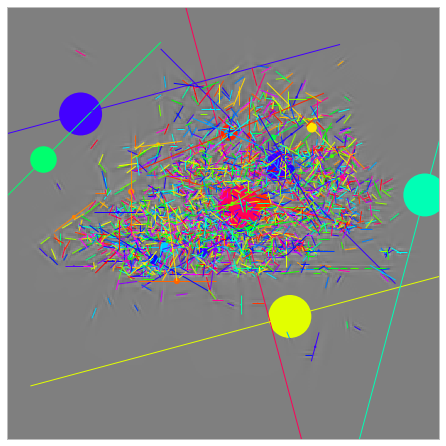

In [22]:
edgeslist_targets[4, :, i_image] = b * a_sign

image_ = ef.reconstruct(edgeslist_shuffled[:, :, i_image])
fig, ax = ef.show_edges(edgeslist_targets[:, :, i_image], image=image_*1.)

0.0595805457725
0.0606733496757


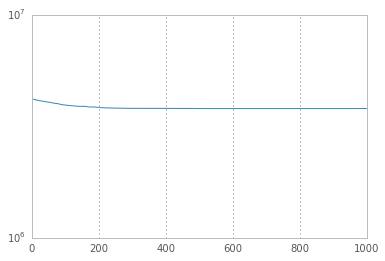

In [23]:
# initialize
edgeslist_new = shuffle(edgeslist_targets[:, :, i_image], N=None)
Weights = np.absolute(edgeslist_new[4, :])
value_sign = edgeslist_new[4, :]/ Weights
Weights[Weights.argsort()] = np.linspace(1./Weights.size, 1., Weights.size)
edgeslist_new[4, :] = value_sign * Weights

v_hist_obs = ef.cohistedges(edgeslist_new[:, :, np.newaxis], display=None)
print  (KL(v_hist_targets, v_hist_obs))
    
# manipulate values
a = np.absolute(edgeslist_new[4, :])
a_sign = edgeslist_new[4, :] / a

g_ij = w_ij(edgeslist_new, v_hist_targets)
#g_ij = w_ij(edgeslist_targets, v_hist_targets)
b, C = solve(a, f=None, g=g_ij)
plt.semilogy(C)
edgeslist_new[4, :] = b * a_sign

v_hist_obs = ef.cohistedges(edgeslist_new[:, :, np.newaxis], display=None)
print  (KL(v_hist_targets, v_hist_obs))

KL_min= 0.0434126528219
KL_min= 0.0438643951804
KL_min= 0.046341962009
KL_min= 0.0410052985836
KL_min= 0.0455567114552
KL_min= 0.0446713128658
KL_min= 0.0502725978397
KL_min= 0.0456045003268
KL_min= 0.044883085327
KL_min= 0.040199209105
KL_min= 0.0420615606903
KL_min= 0.0404378806476
KL_min= 0.0454352535124
KL_min= 0.0447975414404
KL_min= 0.0500966668448
KL_min= 0.0605315474508
KL_min= 0.0617029098607
KL_min= 0.05172199898
KL_min= 0.0461448627964
KL_min= 0.051372823394
KL_min= 0.0433183718777
KL_min= 0.0412475199028
KL_min= 0.0422220006579
KL_min= 0.0397178508218
KL_min= 0.0466740515616
KL_min= 0.0463001863277
KL_min= 0.0384721053849
KL_min= 0.0408422256332
KL_min= 0.0487162774844
KL_min= 0.0488404549404
KL_min= 0.0461794027255
KL_min= 0.0443573428305
KL_min= 0.0458132798688
KL_min= 0.0452319276897
KL_min= 0.0459241213408
KL_min= 0.0423148503295
KL_min= 0.0590059114726
KL_min= 0.0415021402498
KL_min= 0.0457080356139
KL_min= 0.0406233099342
KL_min= 0.0495654945625
KL_min= 0.042466103344

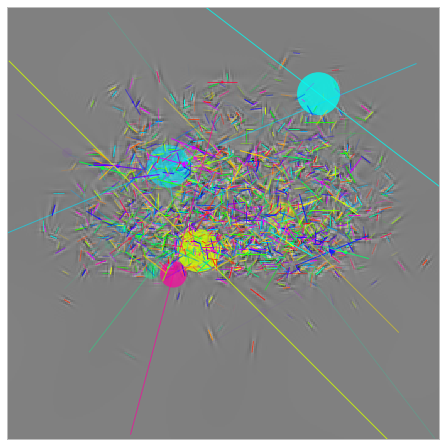

In [24]:
# initialize
edgeslist_shuffled = shuffle(edgeslist_targets[:, :, i_image], N=None)
Weights = np.absolute(edgeslist_shuffled[4, :])
value_sign = edgeslist_shuffled[4, :]/ Weights
Weights[Weights.argsort()] = np.linspace(1./Weights.size, 1., Weights.size)
edgeslist_shuffled[4, :] = value_sign * Weights

#from scipy.stats import entropy
# recurse
def multiply_and_select(edgeslist, v_hist, N_trial=100, N_shuffle=32, N_iter=100):
    for i_iter in range(N_iter):
        KL_min, edgeslist_old = np.inf, edgeslist.copy()
        for i_trial in range(N_trial):
            edgeslist_new = shuffle(edgeslist_old, N=N_shuffle)
            v_hist_obs = ef.cohistedges(edgeslist_new[:, :, np.newaxis], display=None)
            KL_obs = KL(v_hist, v_hist_obs) # entropy(v_hist_obs.ravel(), v_hist.ravel(), base=2)
            #print 'KL=', KL_obs
            if KL_obs<KL_min:
                edgeslist = edgeslist_new
                KL_min = KL_obs
        print ('KL_min=', KL_min)
    return edgeslist

edgeslist_shuffled =  multiply_and_select(edgeslist_shuffled, v_hist_targets)
image_ = ef.reconstruct(edgeslist_shuffled)
fig, ax = ef.show_edges(edgeslist_shuffled, image=image_)

In [25]:
# initialize
edgeslist_shuffled = shuffle(edgeslist_targets[:, :, i_image], N=None)
Weights = np.absolute(edgeslist_shuffled[4, :])
value_sign = edgeslist_shuffled[4, :]/ Weights
Weights[Weights.argsort()] = np.linspace(1./Weights.size, 1., Weights.size)
edgeslist_shuffled[4, :] = value_sign * Weights

#from scipy.stats import entropy
# recurse
def multiply_and_select(edgeslist, v_hist, N_trial=100, N_shuffle=32, N_iter=100):
    for i_iter in range(N_iter):
        KL_min, edgeslist_old = np.inf, edgeslist.copy()
        for i_trial in range(N_trial):
            edgeslist_new = shuffle(edgeslist_old, N=N_shuffle)
            v_hist_obs = ef.cohistedges(edgeslist_new[:, :, np.newaxis], display=None)
            KL_obs = relative_entropy(v_hist_obs.ravel(), v_hist.ravel())
            #print 'KL=', KL_obs
            if KL_obs<KL_min:
                edgeslist = edgeslist_new
                KL_min = KL_obs
        print ('KL_min=', KL_min)
    return edgeslist

edgeslist_shuffled =  multiply_and_select(edgeslist_shuffled, v_hist_targets)
image_ = ef.reconstruct(edgeslist_shuffled)
fig, ax = ef.show_edges(edgeslist_shuffled, image=image_)

NameError: global name 'Dkls' is not defined

In [ ]:
from scipy.stats import entropy
entropy(v_hist_targets.ravel(), qk=v_hist_targets.ravel())

In [ ]:
def adapt_values(edgeslist, v_hist):

    # manipulate values
    a = np.absolute(edgeslist[4, :])
    a_sign = edgeslist[4, :] / a
    g_ij = w_ij(edgeslist, v_hist)
    #g_ij = w_ij(edgeslist, v_hist_targets)
    b, C = solve(a, f=None, g=g_ij)
    edgeslist[4, :] = b * a_sign
    return edgeslist

edgeslist_new = adapt_values(edgeslist_new, v_hist_targets)

In [ ]:
# initialize
edgeslist_shuffled = shuffle(edgeslist_targets[:, :, i_image], N=None)
Weights = np.absolute(edgeslist_shuffled[4, :])
value_sign = edgeslist_shuffled[4, :]/ Weights
Weights[Weights.argsort()] = np.linspace(1./Weights.size, 1., Weights.size)
edgeslist_shuffled[4, :] = value_sign * Weights

#from scipy.stats import entropy
# recurse
def multiply_and_select(edgeslist, v_hist, N_trial=100, N_shuffle=32, N_iter=100):
    for i_iter in range(N_iter):
        KL_min, edgeslist_old = np.inf, edgeslist.copy()
        for i_trial in range(N_trial):
            edgeslist_new = shuffle(edgeslist_old, N=N_shuffle)
            v_hist_obs = ef.cohistedges(edgeslist_new[:, :, np.newaxis], display=None)
            KL_obs = relative_entropy(v_hist_obs.ravel(), v_hist.ravel())
            #print 'KL=', KL_obs
            if KL_obs<KL_min:
                edgeslist = edgeslist_new
                KL_min = KL_obs
        print( 'KL_min=', KL_min)
        edgeslist = adapt_values(edgeslist, v_hist)

        v_hist_obs = ef.cohistedges(edgeslist[:,cv :, np.newaxis], display=None)
        KL_obs = relative_entropy(v_hist_obs.ravel(), v_hist.ravel())
        print ('KL_obs=', KL_obs)
    return edgeslist

edgeslist_shuffled =  multiply_and_select(edgeslist_shuffled, v_hist_targets)
image_ = ef.reconstruct(edgeslist_shuffled)
fig, ax = ef.show_edges(edgeslist_shuffled, image=image_)

## shuffling clusters of edges

In [ ]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
fig_width_pt = 247.  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

In [ ]:
import EdgeFactory as EF
ef = EF.EdgeFactory('default_param.py')

ef.init_edges()
print ef.pe.N_X

In [ ]:
import os, pickle
exp, name_database = 'classifier', 'serre07_targets'
matname = os.path.join('mat/', exp + '_' + name_database)
imagelist = pickle.load( open(matname + '_images.pickle', "rb" ) )
edgeslist_targets = np.load(matname + '_edges.npy')

exp, name_database = 'classifier', 'serre07_distractors'
matname = os.path.join('mat/', exp + '_' + name_database)
edgeslist_distractors = np.load(matname + '_edges.npy')
print edgeslist_distractors.shape

v_hist_distractors = ef.cohistedges(edgeslist_distractors[:, :, i_image][..., np.newaxis], display=None)
print (v_hist_distractors.shape)

In [ ]:
print (edgeslist_distractors[4, :, 0], np.absolute(edgeslist_distractors[4, :, 0]))

In [ ]:
np.random.permutation(10)

In [ ]:
#im.normalize??
#plt.cm.gray?
2048/64
# TODO essayer avec les sous categories _head

In [ ]:
def shuffle(edgeslists, N_cluster=32, seed=None):
    np.random.seed(seed=seed)
    N_image = edgeslists.shape[-1]
    edgeslist_shuffled = np.zeros(edgeslists[:, :, 0].shape)
    size_cluster = edgeslists.shape[1]/N_cluster
    values = np.absolute(edgeslists[4, 0, :]) # absolute values for each cluster
    idx_cluster = np.random.permutation(N_image)
    for i_cluster in range(N_cluster):
        cluster = edgeslists[:, :size_cluster, idx_cluster[i_cluster]].copy()
        # random translation
        cluster[0, :] = np.mod(cluster[0, :].real + np.random.randint(0, pe.N_X), pe.N_X)
        cluster[1, :] = np.mod(cluster[1, :].real + np.random.randint(0, pe.N_X), pe.N_X)
        # random rotation
        #if np.random.rand()>.5:
        #    cluster[0, :] = pe.N_X - cluster[0,:]
        #    cluster[2, :] = - cluster[2,:]
        #if np.random.rand()>.5:
        #    cluster[1, :] = pe.N_X - cluster[1,:]
        #    cluster[3, :] = np.pi - cluster[3,:]
        # random amplitude
        cluster[4, :] *= np.random.randn()#/values[idx_cluster[i_cluster]]
        edgeslist_shuffled[:, (i_cluster*size_cluster):((i_cluster+1)*size_cluster)] = cluster
    return edgeslist_shuffled

In [ ]:
N_trial = 8
fig, ax = plt.subplots(N_trial, 2, figsize=(19, 9*N_trial))
for i_trial in range(N_trial):
    image = ef.normalize(ef.edge.reconstruct(shuffle(edgeslist_distractors, seed=12345+i_trial)))
    ax[i_trial][0].imshow(image, cmap=plt.cm.gray)
    image = im.normalize(ef.edge.reconstruct(shuffle(edgeslist_targets, seed=12345+i_trial+1)))
    ax[i_trial][1].imshow(image, cmap=plt.cm.gray)

In [ ]:
# TODO: check that recognition is still good using SVM
shuffled_edgeslist_distractors = np.zeros(edgeslist_distractors.shape)
for i_image in range(edgeslist_distractors.shape[-1]):
    shuffled_edgeslist_distractors[:, :, i_image] = shuffle(edgeslist_distractors)
shuffled_edgeslist_targets = np.zeros(edgeslist_targets.shape)
for i_image in range(edgeslist_targets.shape[-1]):
    shuffled_edgeslist_targets[:, :, i_image] = shuffle(edgeslist_targets)

In [ ]:
exp = 'classifier'
fone_score = ef.svm(exp, databases=['serre07_distractors', 'serre07_targets'], feature='full')
print ("=> Accuracy = %0.2f +/- %0.2f  " % (fone_score.mean(), fone_score.std()))

In [ ]:
!rm mat/classifier_SVM_shuffled_*_lock
fone_score = ef.svm(exp, databases=['shuffled_serre07_distractors', 'shuffled_serre07_targets'], edgeslists=[shuffled_edgeslist_distractors, shuffled_edgeslist_targets], feature='full')
print ("=> Accuracy = %0.2f +/- %0.2f  " % (fone_score.mean(), fone_score.std()))

In [ ]:
!rm -fr database/shuffled_distractors
# generate images to test psychophysically
if not(os.path.isdir('database/shuffled_distractors')): os.mkdir('database/shuffled_distractors')
for i_image in range(edgeslist_distractors.shape[-1]):
    image_shuffled = im.normalize(ef.edge.reconstruct(shuffled_edgeslist_distractors[:, :, i_image]))
    matname = 'database/shuffled_distractors/image_%03d.png' % i_image
    if not(os.path.isfile(matname)): plt.imsave(matname, image_shuffled, cmap=plt.cm.gray)

In [ ]:
!rm -fr database/shuffled_targets
if not(os.path.isdir('database/shuffled_targets')): os.mkdir('database/shuffled_targets')
for i_image in range(edgeslist_targets.shape[-1]):
    image_shuffled = im.normalize(ef.edge.reconstruct(shuffled_edgeslist_targets[:, :, i_image]))
    matname = 'database/shuffled_targets/image_%03d.png' % i_image
    if not(os.path.isfile(matname)): plt.imsave(matname, image_shuffled, cmap=plt.cm.gray)